In [2]:
import numpy as np
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scram as scram
from scipy.interpolate import interp1d
import importlib
importlib.reload(scram)
from sciris.sc_math import convolve
# import arviz
from tqdm import tqdm

In [4]:
!pip install tqdm

Here, we use a simple hotspot model, where the layer has zero emissivity and opacity. 

In [3]:
# helpful functions

def find_nearest(array, value):
    # Finds the nearest value and index toa  given index in an array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_line_ratio(em1,em2,al1,al2,d,N):
    # Calculates the theoretical line ratio from the analytical solution of the rad. transport equation
    # em1, em2 = emissivity [W/m^3/eV/sr] of lines 1 and 2
    # al1, al2 = opacity [m^-1] of lines 1 and 2
    # N = number of hotspots
    # d [m] = width of hotspot
    I1 = (em1 / al1) * ( 1 - np.exp(-N*al1*d))
    I2 = (em2 / al2) * ( 1 - np.exp(-N*al2*d))
    
    return I1 / I2

# Testing the Code

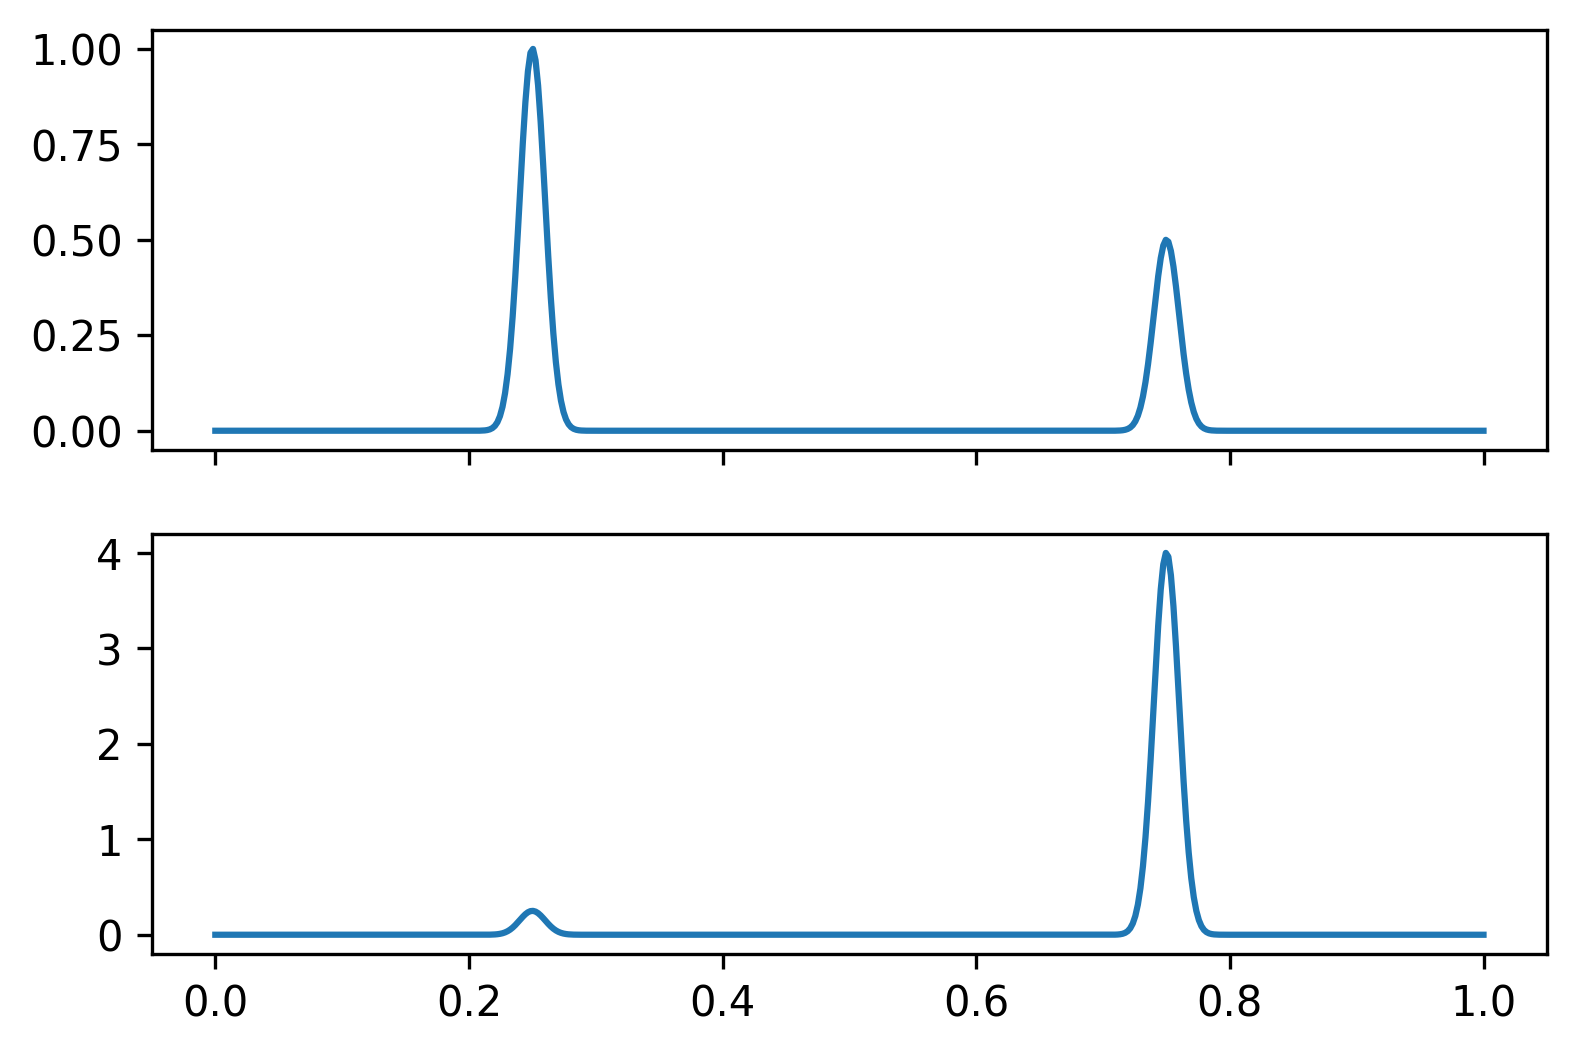

In [3]:
# rad. trans test

ems = [1, 0.5]
ops = [0.25, 4]

w = np.linspace(0,1,500)
emi = ems[0] * scram.gaussian(w,0.25,0.01) + ems[1] * scram.gaussian(w,0.75,0.01) # W/m^3/sr/eV
opa = ops[0] * scram.gaussian(w,0.25,0.01) + ops[1] * scram.gaussian(w,0.75,0.01) # m^-1

fig, axs = plt.subplots(2,1,dpi=300,figsize=(6,4),sharex=True)
axs[0].plot(w,emi)
axs[1].plot(w,opa)

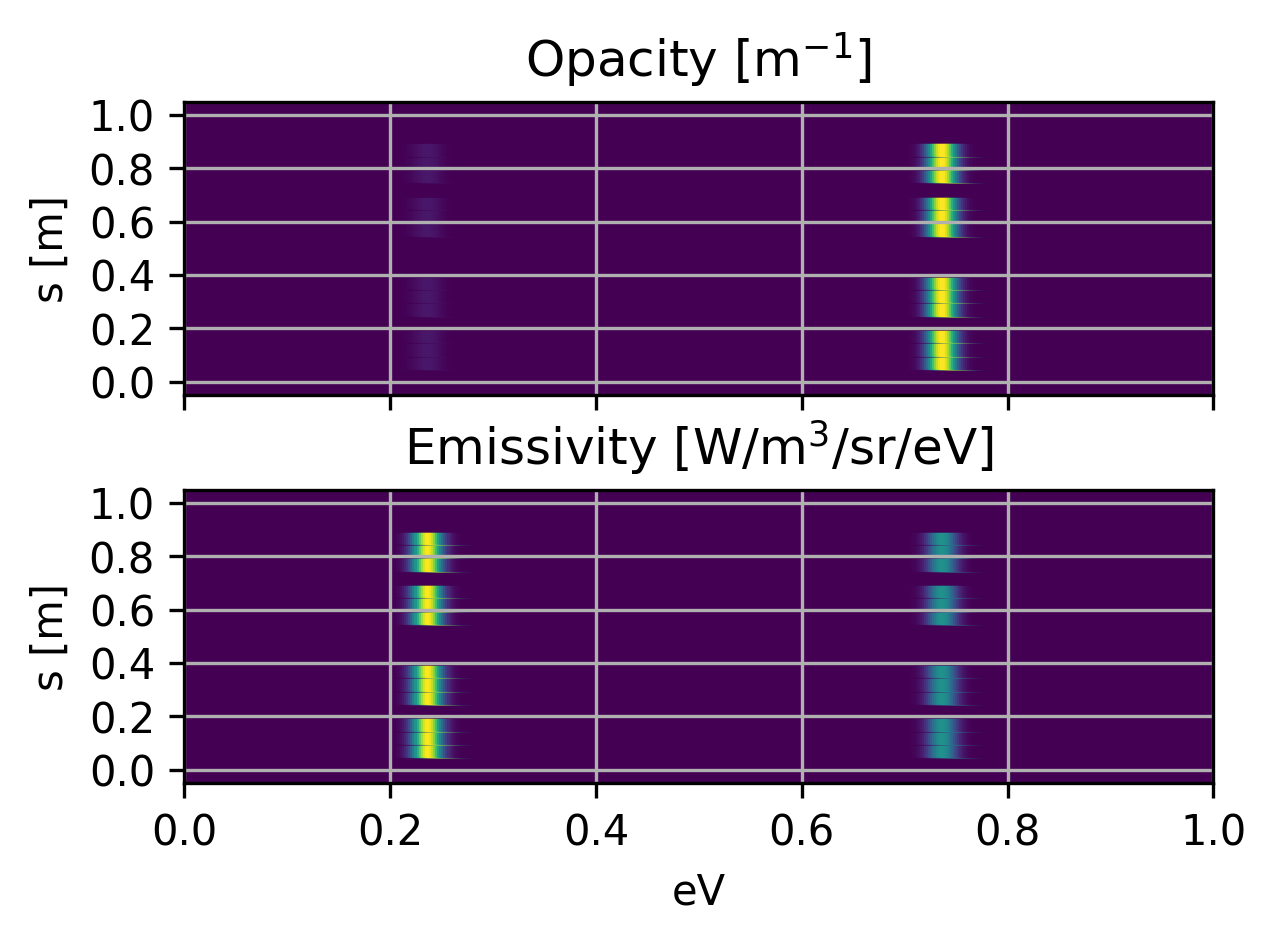

In [4]:
s = np.linspace(0,1,21) # m

m = s.shape[0]
n = w.shape[0]

# Show emissivity and opacity vs photon energy vs s
EM = np.zeros((m,n))
OP = np.zeros((m,n))

d = 3 * np.max(np.diff(s)) # m
    
for ii in range(2,5):
    EM[ii,:] = emi 
    OP[ii,:] = opa

for ii in range(6,9):
    EM[ii,:] = emi 
    OP[ii,:] = opa
    
for ii in range(12,15):
    EM[ii,:] = emi 
    OP[ii,:] = opa

    
for ii in range(16,19):
    EM[ii,:] = emi 
    OP[ii,:] = opa
    
[xx,yy] = np.meshgrid(w,s)

fig, axs = plt.subplots(2,1,figsize=(4,3),dpi=300,sharex=True)
axs[0].scatter(xx, yy, 40, OP, marker='s');
axs[0].set_ylabel('s [m]')
axs[0].set_title('Opacity [m$^{-1}]$')

axs[1].scatter(xx, yy, 40, EM, marker='s');
axs[1].set_ylabel('s [m]')

axs[1].set_xlabel('eV')
axs[1].set_title('Emissivity [W/m$^3$/sr/eV]')

plt.tight_layout(pad=0.2)
axs[1].set_xlim([0,1])

axs[0].grid()
axs[1].grid()

for ii in range(axs.shape[0]):
    axs[ii].set_yticks(np.arange(0,1.2,0.2))
    
plt.show()

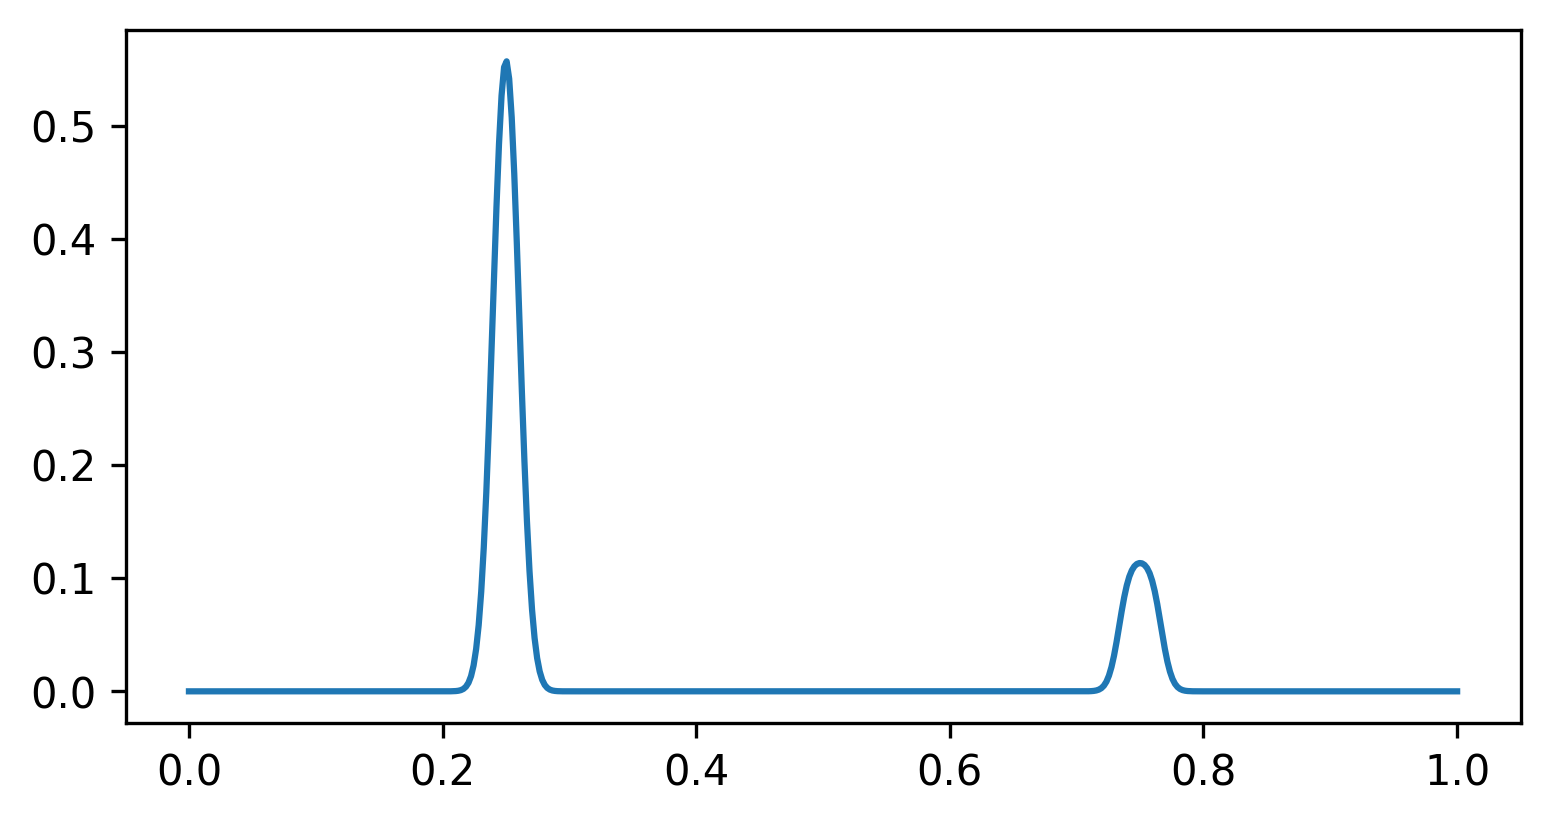

In [9]:
Iin = np.zeros(w.shape) # W/m^2/sr/eV
Iout = scram.radtran(s,Iin,OP,EM)

fig, axs = plt.subplots(1,1,figsize=(6,3),dpi=300,sharex=True)
axs.plot(w,Iout)

# line ratio
idx1,_ = find_nearest(w, 0.25)
idx2,_ = find_nearest(w, 0.75)

sim_line_ratio = Iout[idx1] / Iout[idx2]

In [10]:
# line_ratio = ems[0] / ems[1] * ops[1] / ops[0] * (1 - np.exp(-2*ops[0]*d)) / (1 - np.exp(-2*ops[1]*d))
line_ratio = get_line_ratio(ems[0],ems[1],ops[0],ops[1],d,N=4)

print('Analytical = ', line_ratio)
print('Simulation = ', sim_line_ratio)

Analytical =  4.902048567353785
Simulation =  4.9101907668623666


# Expeirmental Spectrum Analysis

ratio - IC vs Res. =  1.4260005975074856
ratio - IC vs Li. =  1.0812991357814663
ratio - IC vs Spec.. =  3.0745841100330553
ratio - IC vs Res. (Sim) =  1.4256639278816503
ratio - IC vs Li. (Sim) =  1.081299136568385
ratio - IC vs Spec. (Sim) =  3.074584115642247


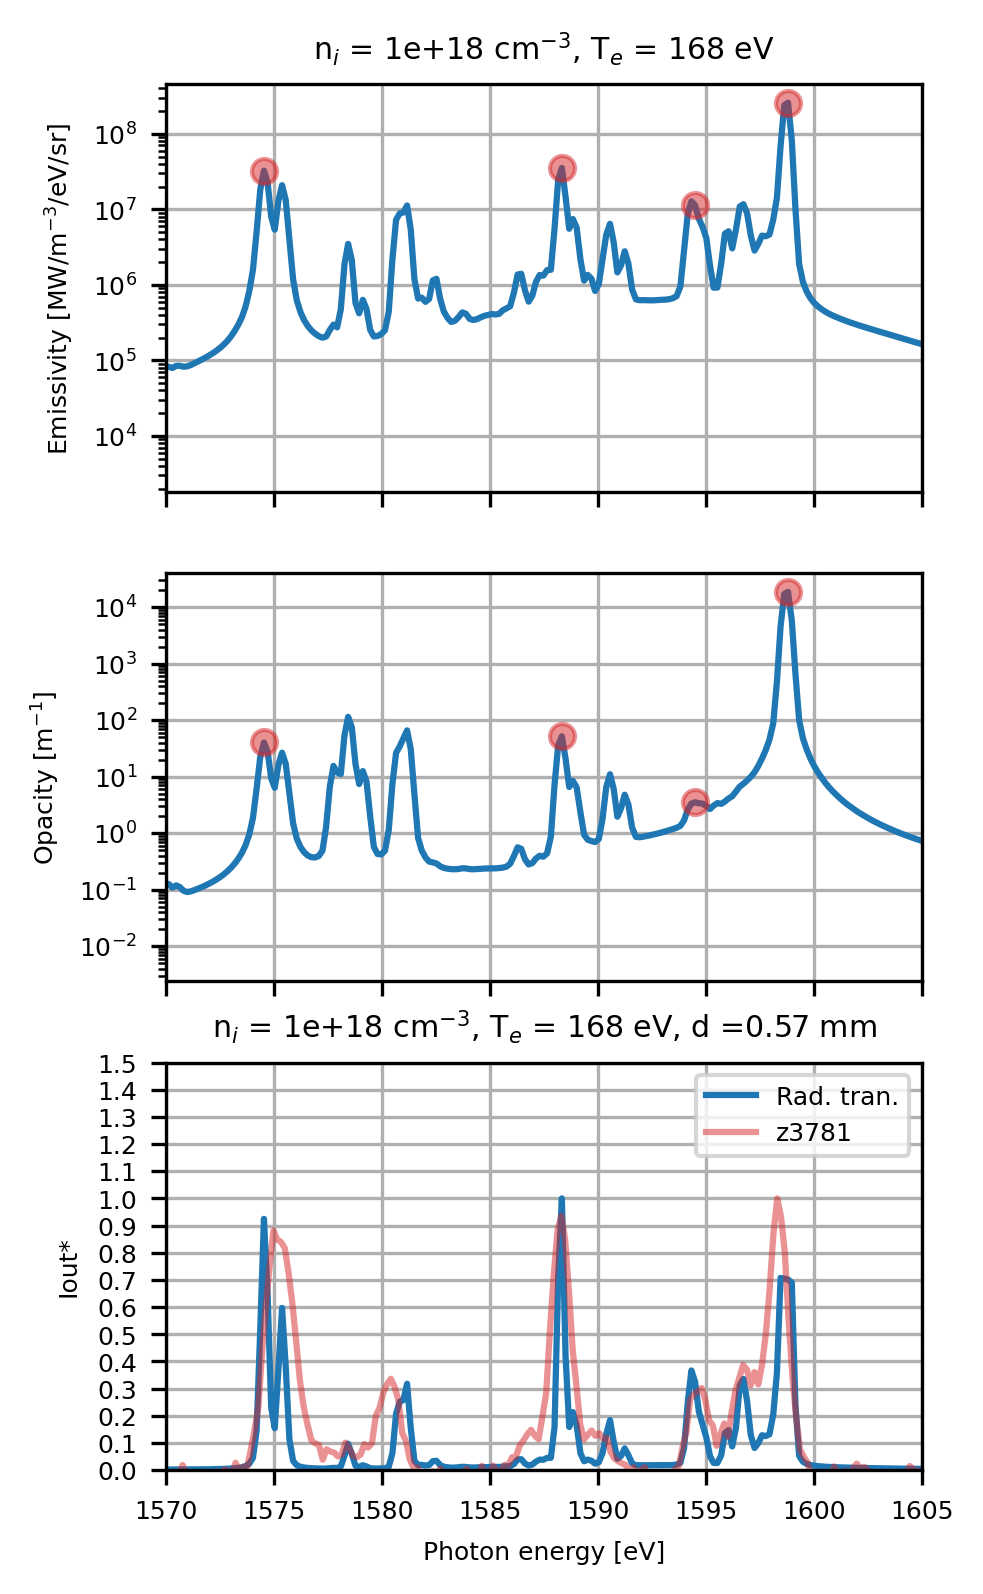

In [4]:
# KNR model
plt.rcParams.update({'font.size': 6})

# Specify Plasma Parameters
ni = 1e18 # cm^-3
T = 168 # eV
d = 0.57e-3 # [m]
# d = 5e-3 [m]

E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV

fig,axs = plt.subplots(3,1,figsize=(6.5/2,6),dpi=300,sharex=True)


# Get emissivity and opacity at the given values of ni and T
emi_knr = scram.getEmi(ni,T) * 1e6 # W/m^3/eV/sr
opa_knr = scram.getOpa(ni,T) * 100 # m^-1


# Lines that we want to match 
idx_1, _ = find_nearest(E,1588.25) # IC line
idx_2, _ = find_nearest(E,1598.75) # Res. line
idx_3, _ = find_nearest(E,1574.6) # Satellite Li-j
idx_4, _ = find_nearest(E,1594.5) # He-alpha Res. Spectator 3d

# Show these lines on emissivity and opacity plots    
axs[1].plot(E,opa_knr,alpha=1)
axs[1].plot(E[idx_1],opa_knr[idx_1],marker='o',color='tab:red',alpha=.5)
axs[1].plot(E[idx_2],opa_knr[idx_2],marker='o',color='tab:red',alpha=.5)
axs[1].plot(E[idx_3],opa_knr[idx_3],marker='o',color='tab:red',alpha=.5)
axs[1].plot(E[idx_4],opa_knr[idx_4],marker='o',color='tab:red',alpha=.5)
axs[1].set_ylabel('Opacity [m$^{-1}$]')
axs[0].plot(E,emi_knr/1e6,alpha=1)
axs[0].plot(E[idx_1],emi_knr[idx_1]/1e6,marker='o',color='tab:red',alpha=.5)
axs[0].plot(E[idx_2],emi_knr[idx_2]/1e6,marker='o',color='tab:red',alpha=.5)
axs[0].plot(E[idx_3],emi_knr[idx_3]/1e6,marker='o',color='tab:red',alpha=.5)
axs[0].plot(E[idx_4],emi_knr[idx_4]/1e6,marker='o',color='tab:red',alpha=.5)
axs[0].set_ylabel('Emissivity [MW/m$^{-3}$/eV/sr]')

    
axs[0].set_title('n$_i$ = ' + str(ni) + ' cm$^{-3}$, T$_e$ = ' + str(T) + ' eV')
axs[-1].set_title('n$_i$ = ' + str(ni) + ' cm$^{-3}$, T$_e$ = ' + str(T) + ' eV' + ', d =' + str(d*1e3) + ' mm')
    
axs[2].set_xlabel("Photon energy [eV]")
axs[2].set_xlim([1570,1605])

axs[0].grid()
axs[1].grid()

axs[1].set_yscale('log')
axs[0].set_yscale('log')

Iout = scram.simulate_homogenous(E,ni,T,d,m=200) # solves radiation transport for homogenous denisty and temp.

# # Uncertainty
# Iout_up = scram.simulate_homogenous(E,ni,T,d+0.2e-3,m=200)
# Iout_down = scram.simulate_homogenous(E,ni,T,d-0.2e-3,m=200)

# Convolution
Iout1= Iout[np.where((E >= 1560) & (E <= 1620))]
E1 = E[np.where((E >= 1560) & (E <= 1620))]
Enew = np.linspace(E1.min(),E1.max(),E1.shape[0]*5)
f = interp1d(E1,Iout1)
Inew = f(Enew)
Inew = Inew / Inew.max()
fwhm = 1.14 * 0.5 # eV for a 0.5 mm source
res = scram.instrument_response(Enew,fwhm)
I_conv = convolve(Inew,res)
I_conv = I_conv / I_conv.max()


axs[2].plot(E,Iout/Iout.max(),label='Rad. tran.')
# axs[2].fill_between(E,Iout_down/Iout_down.max(),Iout_up/Iout_up.max(),alpha=0.2,color='tab:blue',linewidth=0.5) # Uncertianty
# axs[2].plot(Enew,I_conv,color='tab:green',label='Source Broadened',linewidth=1,alpha=0.9)
axs[2].set_ylabel('Iout*')
axs[2].set_ylim(ymin=0)
axs[2].set_yticks(np.arange(0,1.6,0.1))
axs[2].grid()

# inPath = '\\Users\\rdatta\\Dropbox (MIT)\\PUFFIN\\Data\\MARZ\\XRS3\\'
inPath = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/XRS3/'
data = np.loadtxt(inPath + 'z3781_z=10mm.csv',delimiter=',')
Iexp = data[:,1]
Iexp = Iexp / Iexp.max()
Iexp_sd = data[:,2] / data[:,1].max()
axs[2].plot(data[:,0],Iexp,alpha=0.5,marker='',linestyle='-',color='tab:red',
         markerfacecolor='tab:red',markersize=4,label='z3781',markeredgecolor='tab:red',linewidth=1.5)
axs[2].legend()

# line ratios analytical

ratio_1 = get_line_ratio(emi_knr[idx_1],emi_knr[idx_2],opa_knr[idx_1],opa_knr[idx_2],d=d,N=1)
ratio_2 = get_line_ratio(emi_knr[idx_1],emi_knr[idx_3],opa_knr[idx_1],opa_knr[idx_3],d=d,N=1)
ratio_3 = get_line_ratio(emi_knr[idx_1],emi_knr[idx_4],opa_knr[idx_1],opa_knr[idx_4],d=d,N=1)

print('ratio - IC vs Res. = ', ratio_1)
print('ratio - IC vs Li. = ', ratio_2)
print('ratio - IC vs Spec.. = ', ratio_3)

axs[2].set_ylim([0,1.5])

print('ratio - IC vs Res. (Sim) = ', Iout[idx_1]/Iout[idx_2])
print('ratio - IC vs Li. (Sim) = ', Iout[idx_1]/Iout[idx_3])
print('ratio - IC vs Spec. (Sim) = ', Iout[idx_1]/Iout[idx_4])

plt.show()

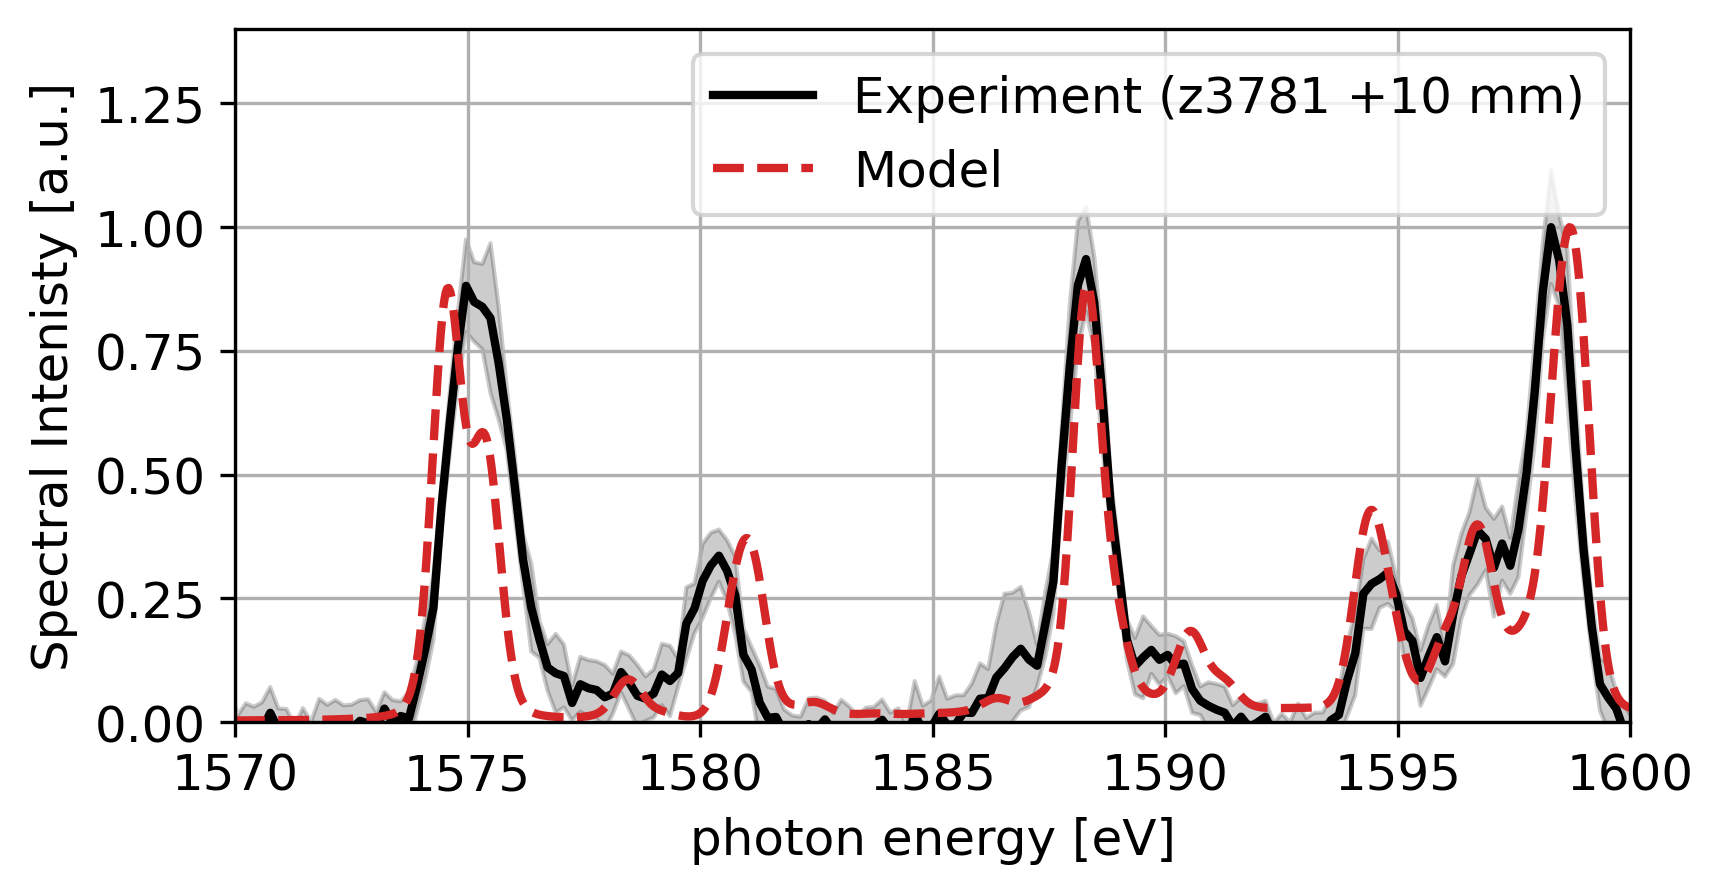

In [5]:
# Show  after convolution

plt.rcParams.update({'font.size': 12})

fig,axs = plt.subplots(1,1,figsize=(6,3),dpi=300,sharex=True)

axs.plot(data[:,0],Iexp,alpha=1,marker='',linestyle='-',color='black',
         markerfacecolor='tab:red',markersize=4,label='Experiment (z3781 +10 mm)',markeredgecolor='black',linewidth=2)
axs.fill_between(data[:,0],Iexp+Iexp_sd,Iexp-Iexp_sd,color='k',alpha=0.2)

axs.plot(Enew,I_conv/I_conv.max(),label='Model',color='tab:red',linewidth=2,linestyle='--')
axs.set_ylabel('Spectral Intenisty [a.u.]')
axs.set_ylim([0,1.4])
axs.set_xlim([1570,1600])
axs.set_xlabel('photon energy [eV]')
axs.grid()
axs.legend()



In [10]:
pred = np.vstack([Enew, I_conv])
savePath = "/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/XRS3/"
np.savetxt(savePath + 'z3781_pred_d_5mm.txt',pred.transpose())

# Compare analytical Line ratio and Full Integral Solution for Hotspot Model

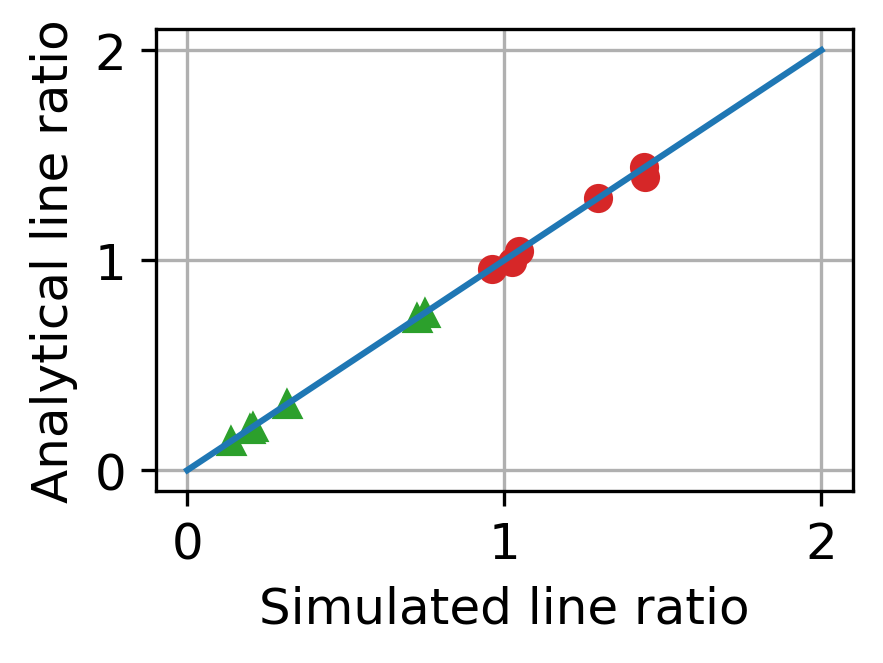

In [16]:
# Test cases

ni = np.array([1e18,1e19,1e20,1e18,1e19,1e20])
T = np.array([100,125,200,150,185,100])

# ni = np.array([1e19])
# T = np.array([180])

fig, axs = plt.subplots(1,1,figsize=(6/2,2),dpi=300)

for ii in range(T.shape[0]):
    E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV
    
    idx_1, _ = find_nearest(E,1588.25) # IC line
    idx_2, _ = find_nearest(E,1598.75) # Res. line
    idx_3, _ = find_nearest(E,1574.6) # Satellite Li-j

    emi_knr = scram.getEmi(ni[ii],T[ii]) * 1e6
    opa_knr = scram.getOpa(ni[ii],T[ii]) * 100
    
    if (ni[ii] == 1e20):
        m = 1200
    else:
        m = 400
    Iout = scram.simulate_homogenous(E,ni[ii],T[ii],0.5e-3,m)
    
    # line ratios analytical

    ratio_1 = get_line_ratio(emi_knr[idx_1],emi_knr[idx_2],opa_knr[idx_1],opa_knr[idx_2],d=0.5e-3,N=1)
    ratio_2 = get_line_ratio(emi_knr[idx_1],emi_knr[idx_3],opa_knr[idx_1],opa_knr[idx_3],d=0.5e-3,N=1)
    
    ratio_sim_1 = Iout[idx_1] / Iout[idx_2] 
    ratio_sim_2 = Iout[idx_1] / Iout[idx_3] 
    
    axs.plot(ratio_1,ratio_sim_1,marker='o',color='tab:red',linestyle='')
    axs.plot(ratio_2,ratio_sim_2,marker='^',color='tab:green',linestyle='')
    
axs.set_xlabel('Simulated line ratio')
axs.set_ylabel('Analytical line ratio')
axs.plot([0,2],[0,2])
axs.grid()

    


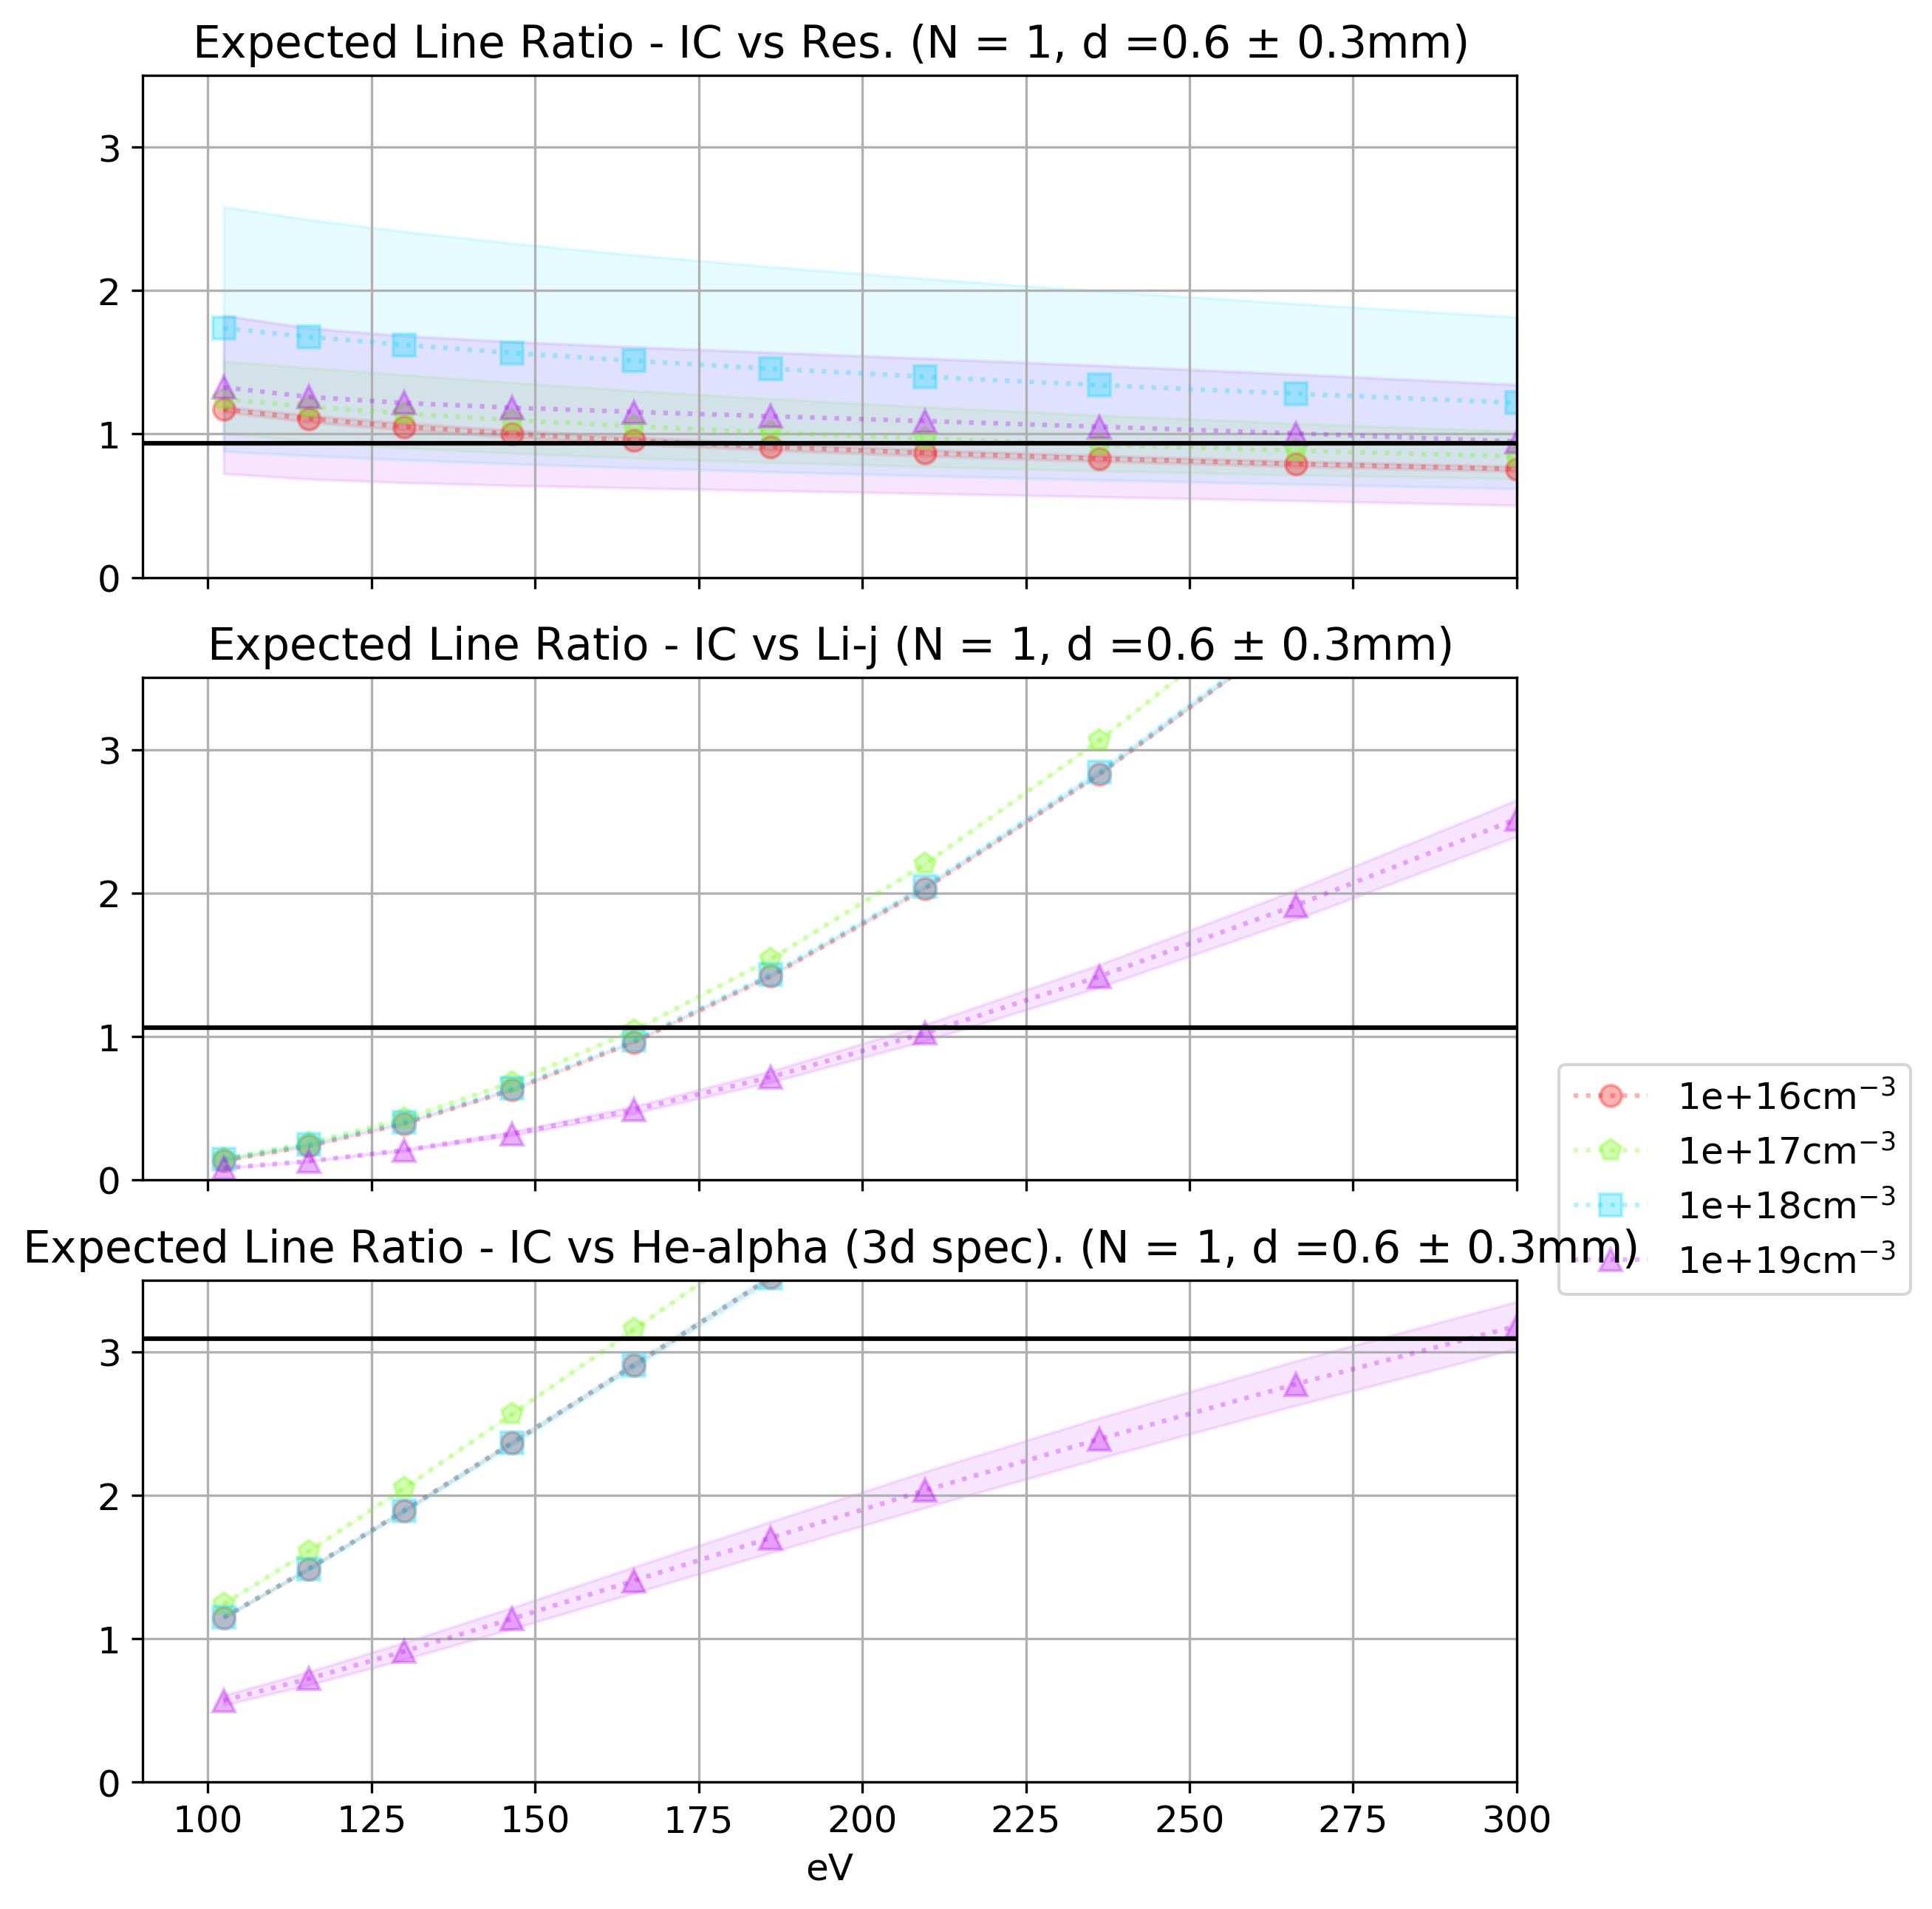

In [9]:
# ni = np.loadtxt('./Al-MARZ2_scram_tables/ni.txt')# cm^-3
ni = np.array([1e16,1e17,1e18,1e19])
T = np.loadtxt('./Al-MARZ2_scram_tables/Te.txt') # eV
T = T[np.where(T >= 100)]


E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV
num = 1
d = 0.6e-3
deld = 0.3e-3


ratio_1 = np.zeros((ni.shape[0],T.shape[0]))
ratio_2 = np.zeros((ni.shape[0],T.shape[0]))
ratio_3 = np.zeros((ni.shape[0],T.shape[0]))

ratio_1_up = np.zeros((ni.shape[0],T.shape[0]))
ratio_2_up = np.zeros((ni.shape[0],T.shape[0]))
ratio_3_up = np.zeros((ni.shape[0],T.shape[0]))

ratio_1_down = np.zeros((ni.shape[0],T.shape[0]))
ratio_2_down = np.zeros((ni.shape[0],T.shape[0]))
ratio_3_down = np.zeros((ni.shape[0],T.shape[0]))


for ii in range(ni.shape[0]):
    for jj in range(T.shape[0]):
        emi = scram.getEmi(ni[ii],T[jj]) * 1e6
        opa = scram.getOpa(ni[ii],T[jj]) * 100

        idx_1, _ = find_nearest(E,1588.25) # IC line
        idx_2, _ = find_nearest(E,1598.75) # Res. line
        idx_3, _ = find_nearest(E,1574.6) # Li-j
        idx_4, _ = find_nearest(E,1594.5) # Spectator 3d

        ratio_1[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_2],opa[idx_1],opa[idx_2],d=d,N=num)
        ratio_2[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_3],opa[idx_1],opa[idx_3],d=d,N=num)
        ratio_3[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_4],opa[idx_1],opa[idx_4],d=d,N=num)
        
        ratio_1_up[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_2],opa[idx_1],opa[idx_2],d=d+deld,N=num)
        ratio_2_up[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_3],opa[idx_1],opa[idx_3],d=d+deld,N=num)
        ratio_3_up[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_4],opa[idx_1],opa[idx_4],d=d+deld,N=num)
        
        ratio_1_down[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_2],opa[idx_1],opa[idx_2],d=d-deld,N=num)
        ratio_2_down[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_3],opa[idx_1],opa[idx_3],d=d-deld,N=num)
        ratio_3_down[ii,jj] = get_line_ratio(emi[idx_1],emi[idx_4],opa[idx_1],opa[idx_4],d=d-deld,N=num)



fig, axs = plt.subplots(3,1,figsize=(8,10),dpi=300,sharex=True)


mkrs = np.array(['o','p','s','^','v','D','P','x','1','2','3','4'])
from matplotlib import cm
clr = cm.hsv(np.linspace(0,0.8,ni.shape[0]))


for ii in range(ni.shape[0]):
    axs[0].plot(T,ratio_1[ii,:],marker=mkrs[ii],color=clr[ii],label=str(ni[ii]) + 'cm$^{-3}$',linestyle=':',markersize=7,alpha=0.3)
    axs[0].fill_between(T,ratio_1_up[ii,:],ratio_1_down[ii,:],color=clr[ii],alpha=0.1)
    
    
    axs[1].plot(T,ratio_2[ii,:],marker=mkrs[ii],color=clr[ii],label=str(ni[ii]) + 'cm$^{-3}$',linestyle=':',markersize=7,alpha=0.3)
    axs[1].fill_between(T,ratio_2_up[ii,:],ratio_2_down[ii,:],color=clr[ii],alpha=0.1)
    
    axs[2].plot(T,ratio_3[ii,:],marker=mkrs[ii],color=clr[ii],label=str(ni[ii]) + 'cm$^{-3}$',linestyle=':',markersize=7,alpha=0.3)
    axs[2].fill_between(T,ratio_3_up[ii,:],ratio_3_down[ii,:],color=clr[ii],alpha=0.1)
    
for ii in range(axs.shape[0]):
    axs[ii].grid()
    axs[ii].set_ylim([0,3.5])
    axs[ii].set_xlim([90,300])
axs[0].plot([50,300],[0.936,0.936],color='k')   # Plot the target line ratios
axs[1].plot([50,300],[1.061,1.061],color='k')  
axs[2].plot([50,300],[3.09,3.09],color='k') 
# axs[2].set_ylim([0,3.2])
axs[0].set_title('Expected Line Ratio - IC vs Res. (N = ' + str(num) + ', d =' + str(d*1e3) +' $\pm$ ' + str(deld*1e3) + 'mm)')
axs[1].set_title('Expected Line Ratio - IC vs Li-j (N = ' + str(num) + ', d =' + str(d*1e3) +' $\pm$ ' + str(deld*1e3) + 'mm)')
axs[2].set_title('Expected Line Ratio - IC vs He-alpha (3d spec). (N = ' + str(num) + ', d =' + str(d*1e3) +' $\pm$ ' + str(deld*1e3) + 'mm)')
axs[-1].set_xlabel('eV')
axs[1].legend(bbox_to_anchor = (1.3, 0), loc='center right')

# Corner Plot analysis

Generate corner plots that show the bounds where the the target line ratios are met

In [20]:
# Make Corner plots

# Random sampling; number of points to sample
N = 10000

E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV
idx_1, _ = find_nearest(E,1588.25) # IC line
idx_2, _ = find_nearest(E,1598.75) # Res. line
idx_3, _ = find_nearest(E,1574.6) # Li-j
idx_4, _ = find_nearest(E,1594.5) # Spectator 3d
num = 1

# Target line ratios
target_1 = 0.936
target_2 = 1.061
target_3 = 3.09

sol_1 = np.zeros((N,3))
sol_2 = np.zeros((N,3))
sol_3 = np.zeros((N,3))

ii = 0
while (ii < N):
    T = 150 * np.random.rand() + 100 # eV
    d = 1e-3 * np.random.rand() + 0.2e-3 # m
    ni = 10**(4 * np.random.rand() + 16) # cm^-3
    
    # caluclate ratio analyically
    emi = scram.getEmi(ni,T) * 1e6
    opa = scram.getOpa(ni,T) * 100
    
    ratio_1 = get_line_ratio(emi[idx_1],emi[idx_2],opa[idx_1],opa[idx_2],d=d,N=1)
    
    # Calculate deviation from target value
    dev = np.abs((ratio_1 - target_1)) / target_1
    if dev <= 0.20: # store value if this is a solution
        sol_1[ii,:] = np.array([T, np.log10(ni), d*1e3])
        ii = ii+ 1
print('Completed 1/3')

ii = 0
while (ii < N):
    T = 150 * np.random.rand() + 100 # eV
    d = 1e-3 * np.random.rand() + 0.2e-3 # m
    ni = 10**(4 * np.random.rand() + 16) # cm^-3
    
    # caluclate ratio analyically
    emi = scram.getEmi(ni,T) * 1e6
    opa = scram.getOpa(ni,T) * 100
    
    ratio_2 = get_line_ratio(emi[idx_1],emi[idx_3],opa[idx_1],opa[idx_3],d=d,N=1)
    
    # Calculate deviation from target value
    dev = np.abs((ratio_2 - target_2)) / target_2
    if dev <= 0.20: # store value if this is a solution
        sol_2[ii,:] = np.array([T, np.log10(ni), d*1e3])
        ii = ii+ 1
print('Completed 2/3')

ii = 0
while (ii < N):
    T = 150 * np.random.rand() + 100 # eV
    d = 1e-3 * np.random.rand() + 0.2e-3 # m
    ni = 10**(4 * np.random.rand() + 16) # cm^-3
    
    # caluclate ratio analyically
    emi = scram.getEmi(ni,T) * 1e6
    opa = scram.getOpa(ni,T) * 100
    
    ratio_3 = get_line_ratio(emi[idx_1],emi[idx_4],opa[idx_1],opa[idx_4],d=d,N=1)
    
    # Calculate deviation from target value
    dev = np.abs((ratio_3 - target_3)) / target_3
    if dev <= 0.20: # store value if this is a solution
        sol_3[ii,:] = np.array([T, np.log10(ni), d*1e3])
        ii = ii+ 1
print('Completed 3/3')


np.save('./Results/sol_1.npy',sol_1)
np.save('./Results/sol_2.npy',sol_2)
np.save('./Results/sol_3.npy',sol_3)


Completed 1/3
Completed 2/3
Completed 3/3


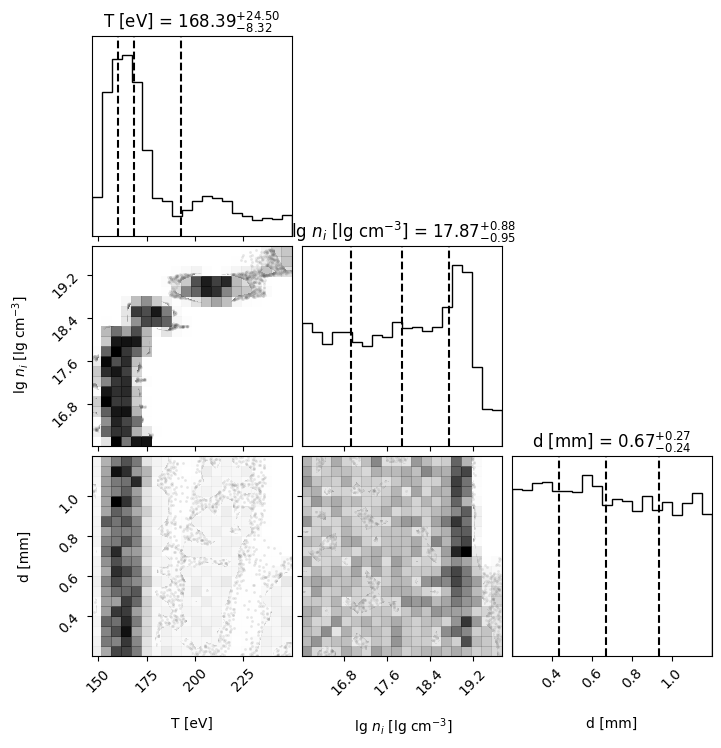

In [34]:
# Visualize the solution

import corner
fig = corner.corner(
    sol_2,
    labels=[
        r"T [eV]",
        r" lg $n_i$ [lg cm$^{-3}$]",
        r"d [mm]"],
    quantiles=[0.25, 0.5, 0.75],
    show_titles=True,
    hist_kwargs={},
    title_kwargs={"fontsize": 12},
    plot_contours=False,
)



Alternate ways to visualize the solution(s)

In [2]:
import pandas as pd

sol_1 = np.load('./Results/sol_1.npy')
sol_2 = np.load('./Results/sol_2.npy')
sol_3 = np.load('./Results/sol_3.npy')

name = 'He-alpha IC vs. Res.'

name = np.tile(name,sol_1.shape[0])
df1 = pd.DataFrame(sol_1, columns = ['T','lg(ni)','d'])
df1.insert(0, "Lines", name, True)

name = 'He-alpha IC vs. Li-j'

name = np.tile(name,sol_2.shape[0])
df2 = pd.DataFrame(sol_2, columns = ['T','lg(ni)','d'])
df2.insert(0, "Lines", name, True)

name = 'He-alpha IC vs. Spec.'

name = np.tile(name,sol_3.shape[0])
df3 = pd.DataFrame(sol_3, columns = ['T','lg(ni)','d'])
df3.insert(0, "Lines", name, True)


data = pd.concat([df1,df2,df3])

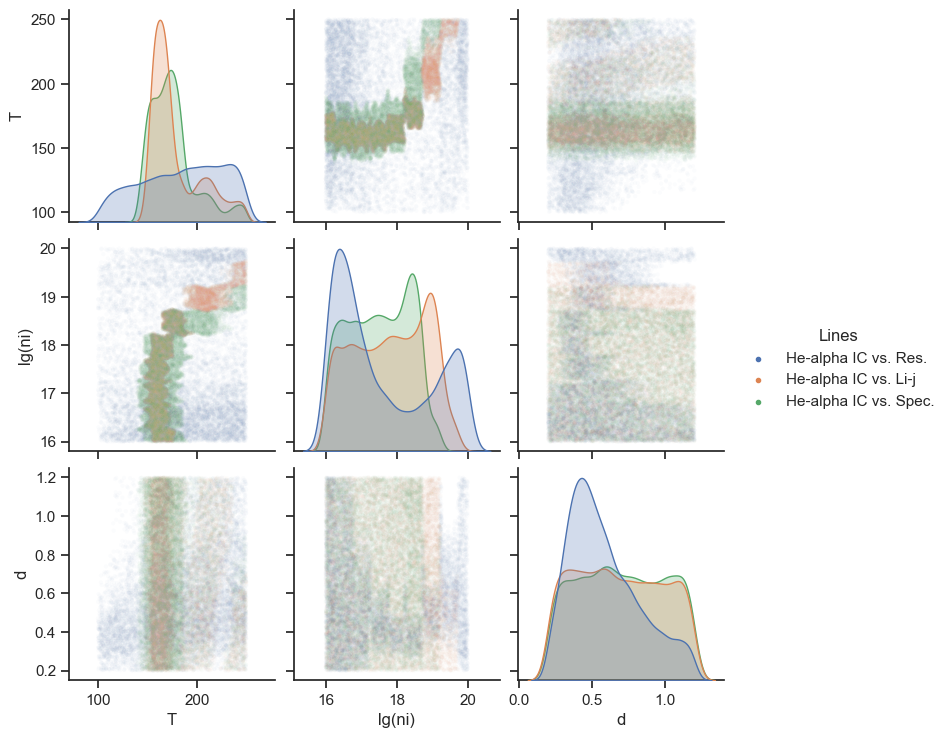

In [20]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(data, hue="Lines", plot_kws={'alpha': 0.02}, markers=['.','.','.'])

In [10]:
# All solutions for all lines
from tqdm import tqdm
import time

# Random sampling
N = 5000

E = np.load('./Al-MARZ2_scram_tables/E.npy') # eV
idx_1, _ = find_nearest(E,1588.25) # IC line
idx_2, _ = find_nearest(E,1598.75) # Res. line
idx_3, _ = find_nearest(E,1574.6) # Li-j
idx_4, _ = find_nearest(E,1594.5) # Spectator 3d
num = 1

target_1 = 0.936
target_2 = 1.061
target_3 = 3.09

sols = np.zeros((N,3))


ii = 0
progress_bar = tqdm(total=N)
while (ii < N):
    T = 150 * np.random.rand() + 100 # eV
    d = 1e-3 * np.random.rand() + 0.2e-3 # m
    ni = 10**(4 * np.random.rand() + 16) # cm^-3
    
    # caluclate ratio analyically
    emi = scram.getEmi(ni,T) * 1e6
    opa = scram.getOpa(ni,T) * 100
    
    ratio_1 = get_line_ratio(emi[idx_1],emi[idx_2],opa[idx_1],opa[idx_2],d=d,N=1)
    ratio_2 = get_line_ratio(emi[idx_1],emi[idx_3],opa[idx_1],opa[idx_3],d=d,N=1)
    ratio_3 = get_line_ratio(emi[idx_1],emi[idx_4],opa[idx_1],opa[idx_4],d=d,N=1)
    
    # Calculate deviation from target value
    dev1 = np.abs((ratio_1 - target_1)) / target_1
    dev2 = np.abs((ratio_2 - target_2)) / target_2
    dev3 = np.abs((ratio_3 - target_3)) / target_3
    if ((dev1 <= 0.20) & (dev2 <= 0.20) & (dev3 <= 0.20)): # store value if this is a solution
        sols[ii,:] = np.array([T, np.log10(ni), d*1e3])
        ii += 1
        time.sleep(0.1)
        progress_bar.update(1)



np.save('./Results/sols.npy',sols)


100%|██████████| 5000/5000 [1:07:44<00:00,  1.13it/s]

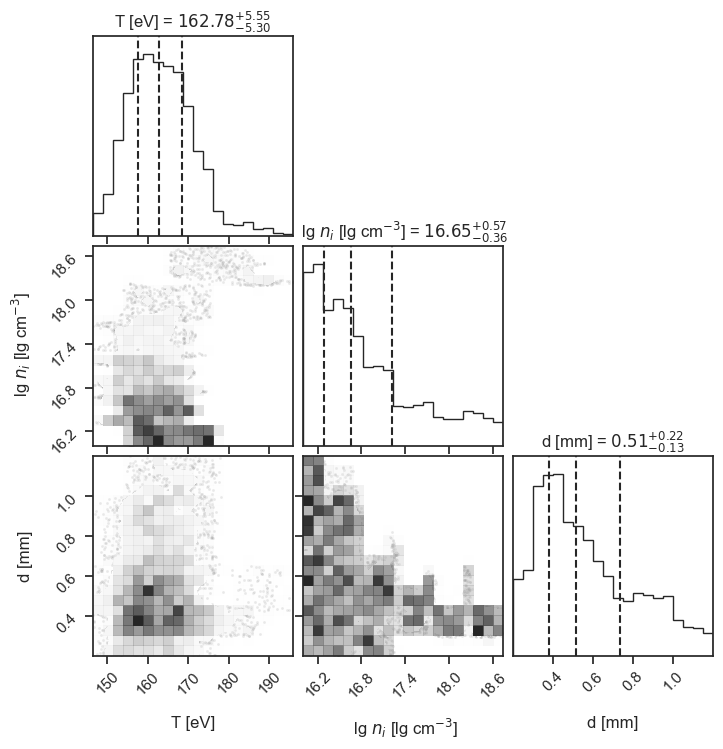

In [11]:
sol_1 = np.load('./Results/sols.npy')

import corner
fig = corner.corner(
    sols,
    labels=[
        r"T [eV]",
        r" lg $n_i$ [lg cm$^{-3}$]",
        r"d [mm]"],
    quantiles=[0.25, 0.5, 0.75],
    show_titles=True,
    hist_kwargs={},
    title_kwargs={"fontsize": 12},
    plot_contours=False,
)


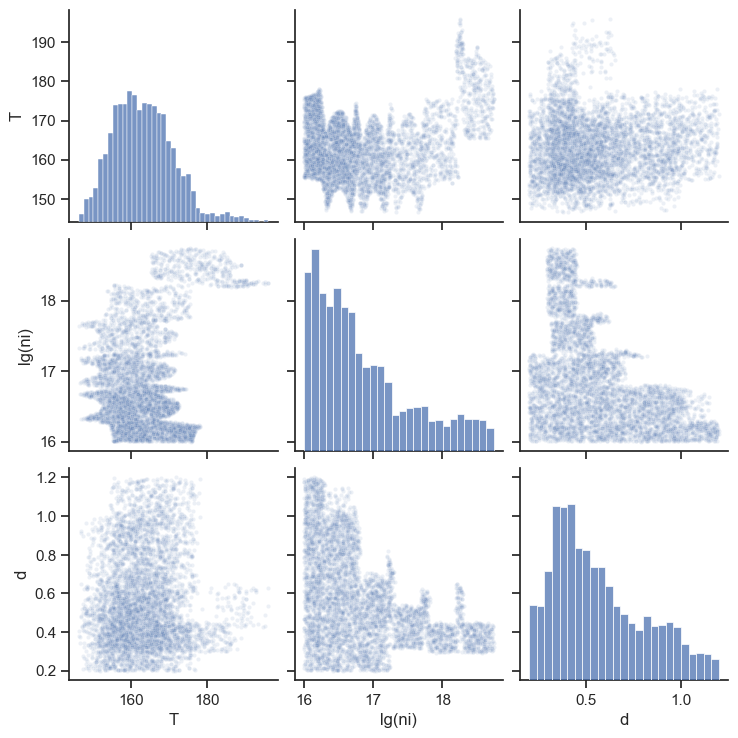

In [17]:
import seaborn as sns
sns.set_theme(style="ticks")

df = pd.DataFrame(sols, columns = ['T','lg(ni)','d'])

sns.pairplot(df,plot_kws={'alpha': 0.1}, markers='.')

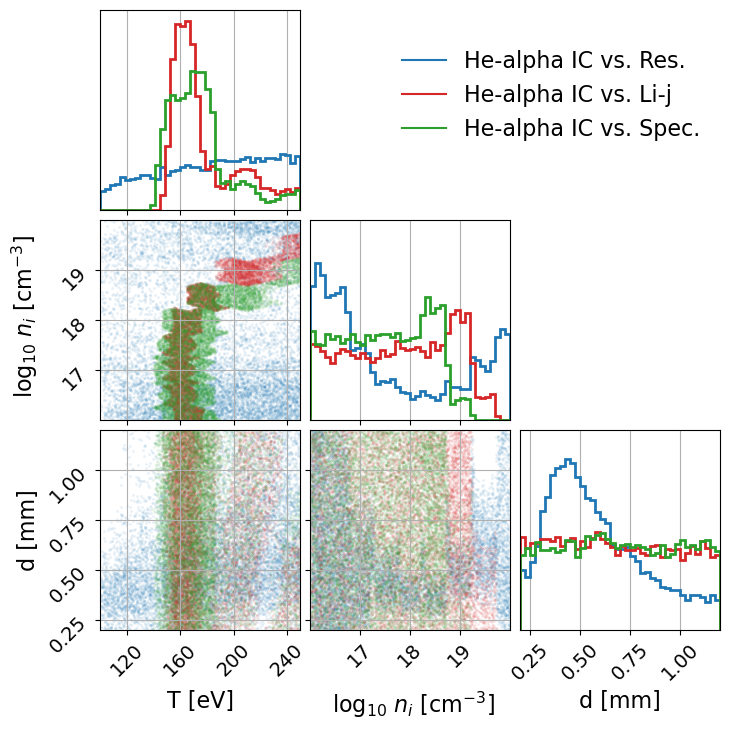

In [13]:
# Multiple corner plots of same figure

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import pandas as pd

sol_1 = np.load('./Results/z3781_z=10mm_sol_1.npy')
sol_2 = np.load('./Results/z3781_z=10mm_sol_2.npy')
sol_3 = np.load('./Results/z3781_z=10mm_sol_3.npy')


# fig = corner.corner(
#     sols,
#     labels=[
#         r"T [eV]",
#         r" lg $n_i$ [lg cm$^{-3}$]",
#         r"d [mm]"],
#     quantiles=[0.25, 0.5, 0.75],
#     show_titles=True,
#     hist_kwargs={},
#     title_kwargs={"fontsize": 12},
#     plot_contours=False,
# )


import corner
# -*- coding: utf-8 -*-
"""Demo to overlay multiple corners on top of each other"""
import corner
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np



CORNER_KWARGS = dict(
    smooth=2,
    bins=40,
    scale_hist=False,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=True,
    plot_contours=False,
    fill_contours=True,
    show_titles=False,
    max_n_ticks=4,
    labels=[
        r"T [eV]",
        r" log$_{10}$ $n_i$ [cm$^{-3}$]",
        r"d [mm]"],
)


def overlaid_corner(samples_list, sample_labels):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('tab10', n+5)
#     colors = [cmap(i) for i in range(n)]
    colors = ['tab:blue','tab:red','tab:green']
    

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    
    
    hist_kwargs = dict(density=False,histtype='step',color=colors[0],alpha=1,
                       edgecolor=colors[0], linewidth=2)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        **CORNER_KWARGS,hist_kwargs=hist_kwargs)

    for idx in range(1, n):
        hist_kwargs = dict(density=False,histtype='step',color=colors[idx],alpha=1,
                           edgecolor=colors[idx], linewidth=2)
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS,
            hist_kwargs=hist_kwargs
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=16, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )


def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)



# overlaid_corner(
#         [sol_2, sol_3, sol_1],
#         ["He-alpha IC vs. Li-j","He-alpha IC vs. Spec."])

overlaid_corner(
        [sol_1, sol_2, sol_3],
        ["He-alpha IC vs. Res.","He-alpha IC vs. Li-j","He-alpha IC vs. Spec."])

plt.gcf().axes[0].set_ylim([0,1.2e3])
plt.gcf().axes[4].set_ylim([0,0.8e3])
plt.gcf().axes[-1].set_ylim([0,0.6e3])
for ii in range(len(plt.gcf().axes)):
    plt.gcf().axes[ii].grid()
    
savePath = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Writing/Figures/PRL/'

fig = plt.gcf()
fig.savefig(savePath + 'corner_1.png',dpi=400)

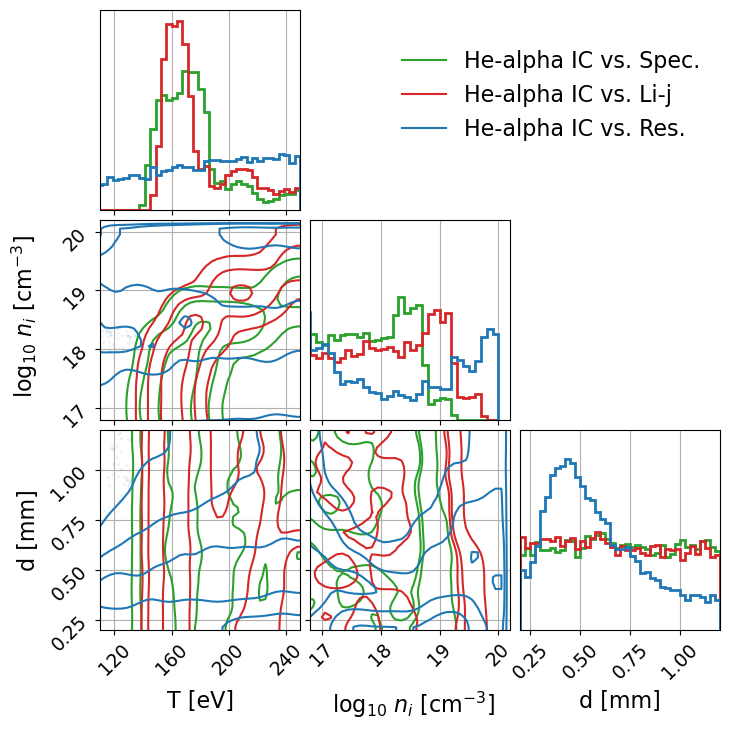

In [21]:
# Multiple corner plots of same figure

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13.5})

import pandas as pd

sol_1 = np.load('./Results/z3781_z=10mm_sol_1.npy')
sol_2 = np.load('./Results/z3781_z=10mm_sol_2.npy')
sol_3 = np.load('./Results/z3781_z=10mm_sol_3.npy')




import corner
# -*- coding: utf-8 -*-
"""Demo to overlay multiple corners on top of each other"""
import corner
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np



CORNER_KWARGS = dict(
    smooth=2,
    bins=40,
    scale_hist=False,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=True,
    plot_contours=True,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,
    labels=[
        r"T [eV]",
        r" log$_{10}$ $n_i$ [cm$^{-3}$]",
        r"d [mm]"],
)


def overlaid_corner(samples_list, sample_labels):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('tab10', n+5)
#     colors = [cmap(i) for i in range(n)]
    colors = ['tab:green','tab:red','tab:blue',]
    

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    
    
    hist_kwargs = dict(density=False,histtype='step',color=colors[0],alpha=1,
                       edgecolor=colors[0], linewidth=2)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        **CORNER_KWARGS,hist_kwargs=hist_kwargs)

    for idx in range(1, n):
        hist_kwargs = dict(density=False,histtype='step',color=colors[idx],alpha=1,
                           edgecolor=colors[idx], linewidth=2)
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS,
            hist_kwargs=hist_kwargs
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=16, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )


def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)



# overlaid_corner(
#         [sol_2, sol_3, sol_1],
#         ["He-alpha IC vs. Li-j","He-alpha IC vs. Spec."])

# overlaid_corner(
#         [sol_1, sol_2, sol_3],
#         ["He-alpha IC vs. Res.","He-alpha IC vs. Li-j","He-alpha IC vs. Spec."])

overlaid_corner(
        [sol_3,sol_2,sol_1],
        ["He-alpha IC vs. Spec.","He-alpha IC vs. Li-j","He-alpha IC vs. Res."])

plt.gcf().axes[0].set_ylim([0,1.2e3])
plt.gcf().axes[4].set_ylim([0,0.8e3])
plt.gcf().axes[-1].set_ylim([0,0.6e3])
plt.gcf().axes[-2].set_xlim([16.8,20.2])
plt.gcf().axes[-2].set_xticks([17,18,19,20])
plt.gcf().axes[4].set_xlim([16.8,20.2])
plt.gcf().axes[4].set_xticks([17,18,19,20])
plt.gcf().axes[3].set_ylim([16.8,20.2])
plt.gcf().axes[3].set_yticks([17,18,19,20])

plt.gcf().axes[3].set_xlim([110,250])
plt.gcf().axes[0].set_xlim([110,250])
plt.gcf().axes[-3].set_xlim([110,250])

# plt.gcf().axes[-1].set_xticks([])

for ii in range(len(plt.gcf().axes)):
    plt.gcf().axes[ii].grid()
    
savePath = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/Figures_POP/'

fig = plt.gcf()
fig.savefig(savePath + 'corner_plot_contours.png',dpi=400)

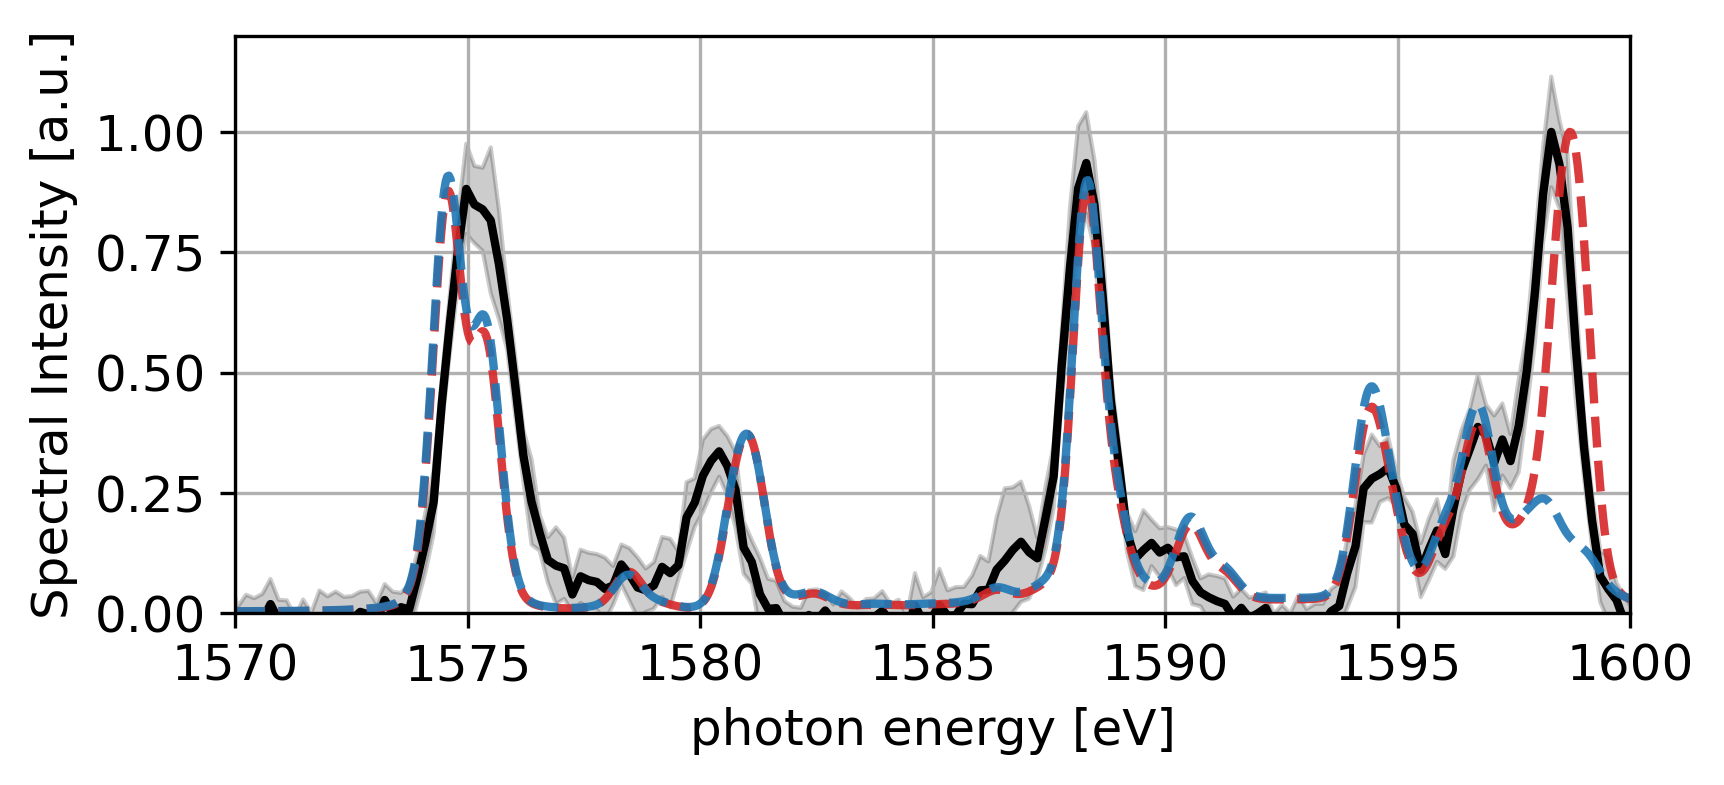

In [13]:
# Example Spectra

inPath = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/XRS3/'
data = np.loadtxt(inPath + 'z3781_z=10mm.csv',delimiter=',')
Iexp = data[:,1]
Iexp = Iexp / Iexp.max()
Iexp_sd = data[:,2] / data[:,1].max()

savePath = "/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/XRS3/"
pred = np.loadtxt(savePath + 'z3781_pred_d_0p5mm.txt')
Enew = pred[:,0]; I_conv = pred[:,1]


plt.rcParams.update({'font.size': 12})

fig,axs = plt.subplots(1,1,figsize=(6,2.5),dpi=300,sharex=True)

axs.plot(data[:,0],Iexp,alpha=1,marker='',linestyle='-',color='black',
         markerfacecolor='tab:red',markersize=4,label='Experiment',markeredgecolor='black',linewidth=2)
axs.fill_between(data[:,0],Iexp+Iexp_sd,Iexp-Iexp_sd,color='k',alpha=0.2)

axs.plot(Enew,I_conv/I_conv.max(),label='Model (d = 0.5 mm)',color='tab:red',linewidth=2,linestyle='--',alpha=0.9)


savePath = "/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/XRS3/"
pred = np.loadtxt(savePath + 'z3781_pred_d_5mm.txt')
Enew = pred[:,0]; I_conv2 = pred[:,1]
axs.plot(Enew,I_conv2/I_conv2.max()/1.1,label='Model (d = 5 mm)',color='tab:blue',linewidth=2,linestyle='--',alpha=0.9)


axs.set_ylabel('Spectral Intensity [a.u.]')
axs.set_ylim([0,1.2])
axs.set_xlim([1570,1600])
axs.set_xlabel('photon energy [eV]')
axs.grid()
# axs.legend(ncol=2)


savePath = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/Figures_POP/'

fig = plt.gcf()
fig.savefig(savePath + 'z3781_XRay_example.png',dpi=400,bbox_inches='tight')